In [1]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
format = "%Y%m%d %H%M"
Date = "20181015"
Time = "1030"
dateTime = pd.to_datetime(Date + " " + Time, format=format)
ticker = "AAPL"
shares = 10000
pct = 0.1 #10% of the volume
dateTime.date()

datetime.date(2018, 10, 15)

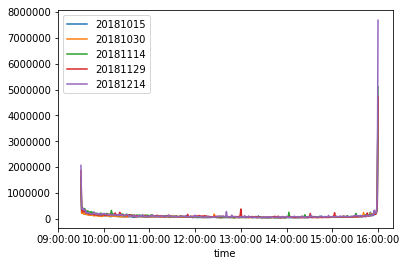

In [3]:
def Volume_profile(Ticker, dateTime, nDays = 10, plot = False):
    i_count = 1
    n_prev_actual = nDays
    actual_Date = dateTime.strftime("%Y%m%d")

    while i_count <= n_prev_actual :
        df = {}

        date_iter = dateTime - datetime.timedelta(days=i_count)
        Date = date_iter.strftime("%Y%m%d")
        if(Date < "20181001"):
            break
        try:
           # print("In try loop")
            data_iter = pd.read_csv("S&P500 - Q4 2018/allstocks_" + Date + "/table_"+ Ticker + ".csv", header = None,
                                    names=["Date", "Time", "Open", "High", 'Low', "Close", "Volume", "a", "b", "c"],
                                    parse_dates=[['Date', 'Time']]) 
            #print(data_iter.head(2))
            format = "%Y%m%d %H%M"
            data_iter["DateTime"] = pd.to_datetime(data_iter.Date_Time, format=format)
            start = pd.to_datetime(Date + " 930", format=format)
            end = pd.to_datetime(Date + " 1600", format=format)
            data_iter = data_iter[data_iter.DateTime >= start]
            data_iter = data_iter[data_iter.DateTime <= end]
            
            df["time"] = [date.time() for date in data_iter.DateTime]
            df[Date] = data_iter.Volume
            df = pd.DataFrame(df)
            if('profile' not in locals()):
                profile = df
            else:
                profile = pd.merge(profile, df,how = "outer", on = "time")
            i_count += 1
        except IOError:
            #print("        Except loop")
            i_count += 1
            n_prev_actual += 1
    #print(profile)
    profile.fillna(0, inplace=True)
    time = profile.time
    profile = profile.drop(["time"], axis = 1)
    Volume = profile.sum(axis= 1)/len(profile.columns)
    #print(Volume)
    if(plot):
        plt.plot(time, Volume, label = actual_Date)
        start = pd.to_datetime(actual_Date + " 900", format=format)
        date_list = [start + datetime.timedelta(minutes=60*x) for x in range(0, 8)]
        times = [date.time() for date in date_list]
        plt.xticks(times)
    func = lambda x : pd.to_datetime( actual_Date + " " + str(x.hour) + str(x.minute), format="%Y%m%d %H%M")
    DateTimes = list(map(func, time))
    return pd.DataFrame({"DateTime" : DateTimes, "Pred_Volume" : Volume})
        
Volume_profile("AAPL", dateTime, plot=True)
Volume_profile("AAPL", dateTime + datetime.timedelta(days=15), plot=True)
Volume_profile("AAPL", dateTime + datetime.timedelta(days=30), plot=True)
Volume_profile("AAPL", dateTime + datetime.timedelta(days=45), plot=True)
Volume_profile("AAPL", dateTime + datetime.timedelta(days=60), plot=True)

plt.legend()
plt.show()


In [4]:
def drift_price(Mid, Drifts):
    price = Mid 
    for i in range(len(Drifts)):
        price += (0.5)**i * Drifts[i]
    return price

In [5]:
def VWAP_Trade_Cost(Date, shares, ticker, pct):
    total_shares = shares
    trades = []
    total_price = 0
    total_drifted_price = 0
    format = "%Y%m%d %H%M"
    Drifts = [0, 0, 0, 0, 0, 0]
    start = pd.to_datetime(Date + " 1030", format=format) #Trade starts at 10:30
    end = pd.to_datetime(Date + " 1600", format=format)
    file = "S&P500 - Q4 2018/allstocks_" + Date + "/table_" + ticker + ".csv"
    if (os.path.exists(file) == 0):
        print("Bad Date = ", Date)


    data = pd.read_csv(file, header = None,
                       names=["Date", "Time", "Open", "High", 'Low', "Close", "Volume", "a", "b", "c"],
                       parse_dates=[['Date', 'Time']]) 
    data["DateTime"] = pd.to_datetime(data.Date_Time, format=format)
    data["Mid"] = (data["High"] + data["Low"] + data["Open"] + data["Close"]) / 4
    
    data = data[["DateTime", "Open", "High", "Low", "Close", "Mid", "Volume"]]
    filtered_data = data[(data.DateTime >= start) & (data.DateTime <= end)]
    filtered_data = filtered_data.reset_index(drop=True)
    curr_price = filtered_data.Mid[0]
    total_price = 0
    total_drifted_price = 0
    Highest_Price = curr_price

    for row in filtered_data.itertuples():
        if ((np.isnan(row.Volume)) or (row.Volume == 0)):
            continue 
        else:
            Volume = row.Volume
            traded_Volume = min(int(Volume * pct), shares)
            Mid_price = row.Mid
            Drifts.insert(0,0.2*(np.sqrt(traded_Volume/Volume))*(row.High - row.Mid))
            Drifts.pop(-1)
            drifted_price = drift_price(Mid_price, Drifts)
            if(drifted_price > Highest_Price):
                Highest_Price = drifted_price
            trades.append({"Time" : row.DateTime, "Volume" : traded_Volume, "Price" : Mid_price, 
                           "Drifted_Price": drifted_price, "actual_Volume" : Volume})
            total_price += traded_Volume * Mid_price
            total_drifted_price += traded_Volume * drifted_price
            shares -= traded_Volume
            if(shares == 0):
                break
        
    Price_Per_Share = total_price / (total_shares - shares)
    Drifted_Price_Per_Share = total_drifted_price / (total_shares - shares)
    rtn = {"Total_Price" : total_price, "Price_Per_Share" : Price_Per_Share, 
           "Total_Drifted_Price" : total_drifted_price, "Drifted_Price_Per_Share" : Drifted_Price_Per_Share,
           "Price_Impact" : Drifted_Price_Per_Share - curr_price,
           "Price_Impact(bps)" : (Drifted_Price_Per_Share - curr_price)*10000 / curr_price,
           "Trades" : pd.DataFrame(trades),
           "Shortfall" : shares, "filtered_data" : filtered_data, 
           "Highest_Price" : Highest_Price}
    return rtn
VWAP_result = VWAP_Trade_Cost("20181010", 3e6, "AAPL", 0.1)
print("average traded price : ", VWAP_result[ "Price_Per_Share" ])
print("average drifted price :", VWAP_result[ "Drifted_Price_Per_Share" ])
print(VWAP_result[ "Trades" ])

average traded price :  219.162728535
average drifted price : 219.190919338
     Drifted_Price      Price                Time    Volume  actual_Volume
0       221.889996  221.86650 2018-10-10 10:30:00   11186.0       111862.0
1       222.106612  222.08250 2018-10-10 10:31:00    5630.0        56306.3
2       221.930004  221.90100 2018-10-10 10:32:00    5486.0        54867.2
3       221.734427  221.70500 2018-10-10 10:33:00    3822.0        38227.6
4       221.666640  221.63950 2018-10-10 10:34:00    6917.0        69179.9
5       221.651099  221.62575 2018-10-10 10:35:00    6908.0        69084.1
6       221.746050  221.71975 2018-10-10 10:36:00    7615.0        76156.8
7       221.883592  221.85650 2018-10-10 10:37:00    6071.0        60715.4
8       221.882557  221.85775 2018-10-10 10:38:00    4850.0        48504.0
9       221.723961  221.70300 2018-10-10 10:39:00    3897.0        38970.3
10      221.717159  221.69775 2018-10-10 10:40:00    5144.0        51446.8
11      221.758204  221.

In [6]:
def VWAP_Trade_Cost_Profile(Date, shares, ticker, pct):
    total_shares = shares
    trades = []
    total_price = 0
    total_drifted_price = 0
    format = "%Y%m%d %H%M"
    Drifts = [0, 0, 0, 0, 0, 0]
    start = pd.to_datetime(Date + " 1030", format=format) #Trade starts at 10:30
    end = pd.to_datetime(Date + " 1600", format=format)
    file = "S&P500 - Q4 2018/allstocks_" + Date + "/table_" + ticker + ".csv"
    if (os.path.exists(file) == 0):
        print("Bad Date = ", Date)


    data = pd.read_csv(file, header = None,
                       names=["Date", "Time", "Open", "High", 'Low', "Close", "Volume", "a", "b", "c"],
                       parse_dates=[['Date', 'Time']]) 
    data["DateTime"] = pd.to_datetime(data.Date_Time, format=format)
    data["Mid"] = (data["High"] + data["Low"] + data["Open"] + data["Close"]) / 4
    profile = Volume_profile(ticker, start, plot=True)
    data = pd.merge(data, profile,how = "left", on = "DateTime",)
    data = data[["DateTime", "Open", "High", "Low", "Close", "Mid", "Volume", "Pred_Volume"]]
    filtered_data = data[(data.DateTime >= start) & (data.DateTime <= end)]
    filtered_data = filtered_data.reset_index(drop=True)
    curr_price = filtered_data.Mid[0]
    total_price = 0
    total_drifted_price = 0
    Highest_Price = curr_price

    for row in filtered_data.itertuples():
        if ((np.isnan(row.Volume)) or (row.Volume == 0)):
            continue 
        else:
            Volume = row.Volume
            traded_Volume = min(int(row.Pred_Volume * pct), shares)
            Mid_price = row.Mid
            Drifts.insert(0,0.2*(np.sqrt(traded_Volume/Volume))*(row.High - row.Mid))
            Drifts.pop(-1)
            drifted_price = drift_price(Mid_price, Drifts)
            if(drifted_price > Highest_Price):
                Highest_Price = drifted_price
            trades.append({"Time" : row.DateTime, "Volume" : traded_Volume, "Price" : Mid_price, 
                           "Drifted_Price": drifted_price, "actual_Volume" : Volume})            
            total_price += traded_Volume * Mid_price
            total_drifted_price += traded_Volume * drifted_price
            shares -= traded_Volume
            if(shares == 0):
                break
        
    Price_Per_Share = total_price / (total_shares - shares)
    Drifted_Price_Per_Share = total_drifted_price / (total_shares - shares)
    rtn = {"Total_Price" : total_price, "Price_Per_Share" : Price_Per_Share, 
           "Total_Drifted_Price" : total_drifted_price, "Drifted_Price_Per_Share" : Drifted_Price_Per_Share, 
           "Price_Impact" : Drifted_Price_Per_Share - curr_price,
           "Price_Impact(bps)" : (Drifted_Price_Per_Share - curr_price)*10000 / curr_price,
           "Trades" : pd.DataFrame(trades),
           "Shortfall" : shares, "filtered_data" : filtered_data, 
           "Highest_Price" : Highest_Price}
    return rtn
VWAP_Profile_result = VWAP_Trade_Cost_Profile("20181010", 3e6, "AAPL", 0.1)
print("average traded price : ", VWAP_Profile_result[ "Price_Per_Share" ])
print("average drifted price :", VWAP_Profile_result[ "Drifted_Price_Per_Share" ])
print(VWAP_Profile_result[ "Trades" ])

average traded price :  219.459615364
average drifted price : 219.482046596
     Drifted_Price      Price                Time  Volume  actual_Volume
0       221.885601  221.86650 2018-10-10 10:30:00    7393       111862.0
1       222.105678  222.08250 2018-10-10 10:31:00    6840        56306.3
2       221.934399  221.90100 2018-10-10 10:32:00    9084        54867.2
3       221.740956  221.70500 2018-10-10 10:33:00    6363        38227.6
4       221.672888  221.63950 2018-10-10 10:34:00   10636        69179.9
5       221.654639  221.62575 2018-10-10 10:35:00    7404        69084.1
6       221.747635  221.71975 2018-10-10 10:36:00    7342        76156.8
7       221.884292  221.85650 2018-10-10 10:37:00    6009        60715.4
8       221.883564  221.85775 2018-10-10 10:38:00    5486        48504.0
9       221.726694  221.70300 2018-10-10 10:39:00    6199        38970.3
10      221.718523  221.69775 2018-10-10 10:40:00    5194        51446.8
11      221.758770  221.73975 2018-10-10 10:41:0

In [7]:
dirs = os.listdir(os.getcwd() + "/S&P500 - Q4 2018")
dirs.remove(".DS_Store")

In [8]:
def Volume_profile_plot(Ticker, num = 5):
    plt.figure(figsize=(20,10))
    plt.ylim(0,1e6)

    i = 0
    for directory in dirs:
        data = pd.read_csv("S&P500 - Q4 2018/" + directory + "/table_"+ Ticker + ".csv", header = None,
                       names=["Date", "Time", "Open", "High", 'Low', "Close", "Volume", "a", "b", "c"],
                      parse_dates=[['Date', 'Time']]) 
        date = directory.replace("allstocks_", "")
        Volume = data.Volume
        format = "%Y%m%d %H%M"
        dates = pd.to_datetime(data.Date_Time, format=format)
        time = [date.time() for date in dates]
        plt.plot(time, Volume)

        i += 1
        if(i == num): 
            break
    start = pd.to_datetime("20181001 700", format=format)
    date_list = [start + datetime.timedelta(minutes=60*x) for x in range(0, 15)]
    times = [date.time() for date in date_list]
    plt.xticks(times)
    plt.show()


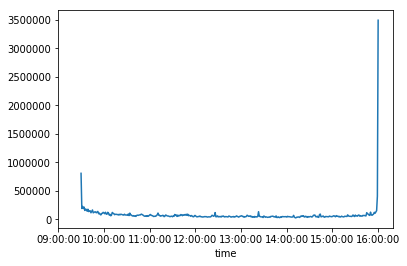

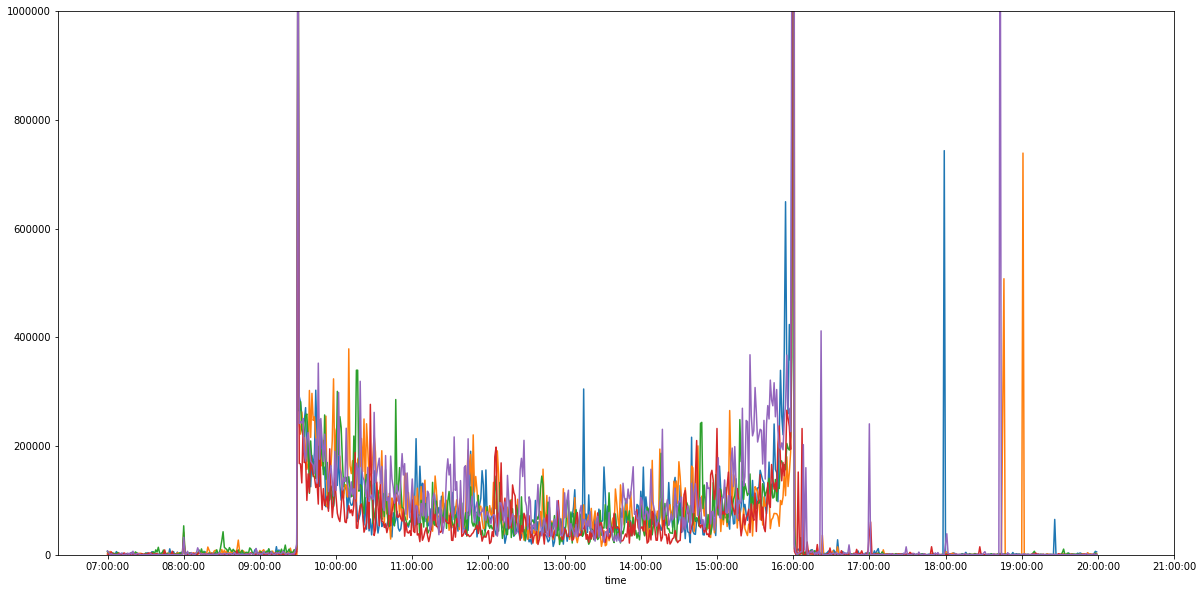

In [9]:
Volume_profile_plot("AAPL")

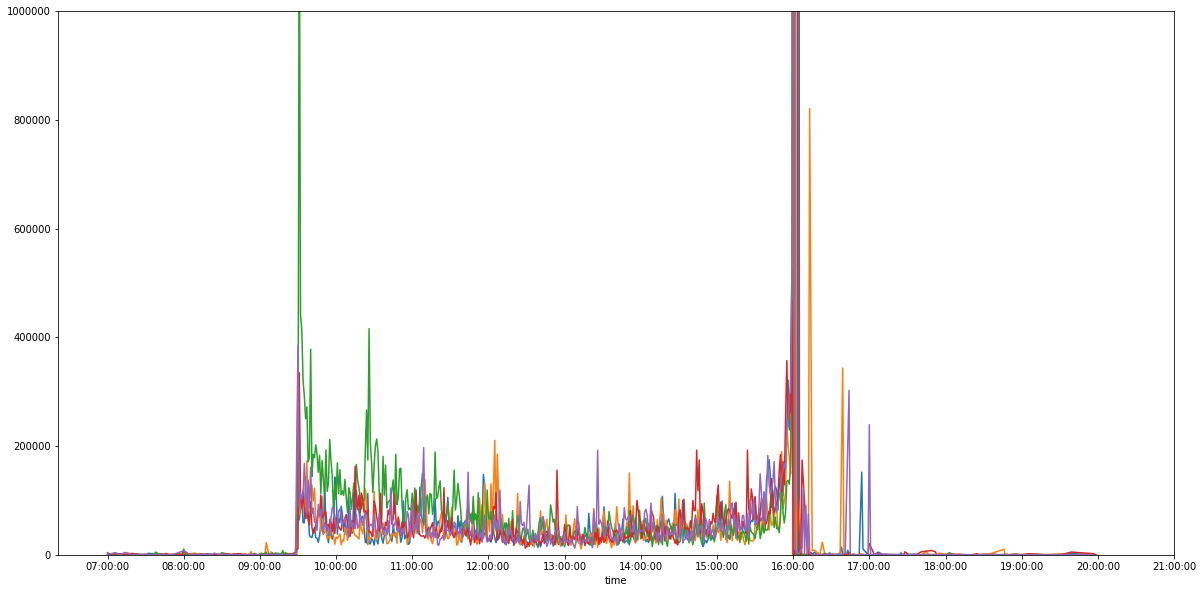

In [10]:
Volume_profile_plot("C")

In [11]:
def POV_Trade_Cost(Date, shares, ticker, pct):
    total_shares = shares
    trades = []
    total_price = 0
    total_drifted_price = 0
    format = "%Y%m%d %H%M"
    Drifts = [0, 0, 0, 0, 0, 0]
    start = pd.to_datetime(Date + " 1030", format=format) #Trade starts at 10:30
    end = pd.to_datetime(Date + " 1600", format=format)
    file = "S&P500 - Q4 2018/allstocks_" + Date + "/table_" + ticker + ".csv"
    if (os.path.exists(file) == 0):
        print("Bad Date = ", Date)


    data = pd.read_csv(file, header = None,
                       names=["Date", "Time", "Open", "High", 'Low', "Close", "Volume", "a", "b", "c"],
                       parse_dates=[['Date', 'Time']]) 
    data["DateTime"] = pd.to_datetime(data.Date_Time, format=format)
    data["Mid"] = (data["High"] + data["Low"] + data["Open"] + data["Close"]) / 4
    
    Volume_Data = data.Volume
    DateTimes = [dt + datetime.timedelta(minutes=1) for dt in data.DateTime]
    prev_Volume = pd.DataFrame({"DateTime" : DateTimes, "Prev_Volume" : Volume_Data})
    data = pd.merge(data, prev_Volume,how = "left", on = "DateTime",)
    data = data[["DateTime", "Open", "High", "Low", "Close", "Mid", "Volume", "Prev_Volume"]]
    filtered_data = data[(data.DateTime >= start) & (data.DateTime <= end)]
    filtered_data = filtered_data.reset_index(drop=True)
    curr_price = filtered_data.Mid[0]
    total_price = 0
    total_drifted_price = 0
    Highest_Price = curr_price

    for row in filtered_data.itertuples():
        if ((np.isnan(row.Volume)) or (row.Volume == 0)):
            continue 
        else:
            Volume = row.Volume
            traded_Volume = min(int(row.Prev_Volume * pct), shares)
            Mid_price = row.Mid
            Drifts.insert(0,0.2*(np.sqrt(traded_Volume/Volume))*(row.High - row.Mid))
            Drifts.pop(-1)
            drifted_price = drift_price(Mid_price, Drifts)
            if(drifted_price > Highest_Price):
                Highest_Price = drifted_price
            trades.append({"Time" : row.DateTime, "Volume" : traded_Volume, "Price" : Mid_price, 
                           "Drifted_Price": drifted_price, "actual_Volume" : Volume})            
            total_price += traded_Volume * Mid_price
            total_drifted_price += traded_Volume * drifted_price
            shares -= traded_Volume
            if(shares == 0):
                break
        
    Price_Per_Share = total_price / (total_shares - shares)
    Drifted_Price_Per_Share = total_drifted_price / (total_shares - shares)
    rtn = {"Total_Price" : total_price, "Price_Per_Share" : Price_Per_Share, 
           "Total_Drifted_Price" : total_drifted_price, "Drifted_Price_Per_Share" : Drifted_Price_Per_Share, 
           "Price_Impact" : Drifted_Price_Per_Share - curr_price,
           "Price_Impact(bps)" : (Drifted_Price_Per_Share - curr_price)*10000 / curr_price,
           "Trades" : pd.DataFrame(trades),
           "Shortfall" : shares, "filtered_data" : filtered_data, 
           "Highest_Price" : Highest_Price}
    return rtn
POV_result = POV_Trade_Cost("20181010", 3e6, "AAPL", 0.1)
print("average traded price : ", POV_result[ "Price_Per_Share" ])
print("average drifted price :", POV_result[ "Drifted_Price_Per_Share" ])
print(POV_result[ "Trades" ])

average traded price :  219.280908815
average drifted price : 219.307713802
     Drifted_Price      Price                Time  Volume  actual_Volume
0       221.883158  221.86650 2018-10-10 10:30:00    5623       111862.0
1       222.108257  222.08250 2018-10-10 10:31:00   11186        56306.3
2       221.931048  221.90100 2018-10-10 10:32:00    5630        54867.2
3       221.737905  221.70500 2018-10-10 10:33:00    5486        38227.6
4       221.665190  221.63950 2018-10-10 10:34:00    3822        69179.9
5       221.650382  221.62575 2018-10-10 10:35:00    6917        69084.1
6       221.745133  221.71975 2018-10-10 10:36:00    6908        76156.8
7       221.884749  221.85650 2018-10-10 10:37:00    7615        60715.4
8       221.884502  221.85775 2018-10-10 10:38:00    6071        48504.0
9       221.725904  221.70300 2018-10-10 10:39:00    4850        38970.3
10      221.716998  221.69775 2018-10-10 10:40:00    3897        51446.8
11      221.757486  221.73975 2018-10-10 10:41:0

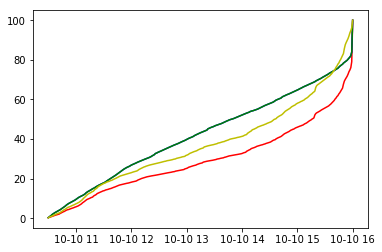

In [12]:
VWAP = VWAP_Profile_result[ "Trades" ]
Approx_VWAP = VWAP_Profile_result[ "Trades" ]
POV = POV_result[ "Trades" ]
actual_Volume_pct = np.cumsum(VWAP.actual_Volume)*100 / np.cumsum(VWAP.actual_Volume)[len(VWAP.actual_Volume) - 1]
VWAP_Volume_pct = np.cumsum(VWAP.Volume)*100 / np.cumsum(VWAP.Volume)[len(VWAP.Volume) - 1]
Approx_VWAP_Volume_pct = np.cumsum(Approx_VWAP.Volume)*100 / np.cumsum(Approx_VWAP.Volume)[len(Approx_VWAP.Volume) - 1]
POV_Volume_pct = np.cumsum(POV.Volume)*100 / np.cumsum(POV.Volume)[len(POV.Volume) - 1]

plt.plot(VWAP.Time,actual_Volume_pct, color = 'r', label = "actual volume(%)")

plt.plot(VWAP.Time,VWAP_Volume_pct, color = 'b', label = "VWAP(%)")
plt.plot(Approx_VWAP.Time,Approx_VWAP_Volume_pct, color = 'g')
plt.plot(POV.Time,POV_Volume_pct, color = 'y')

plt.show()

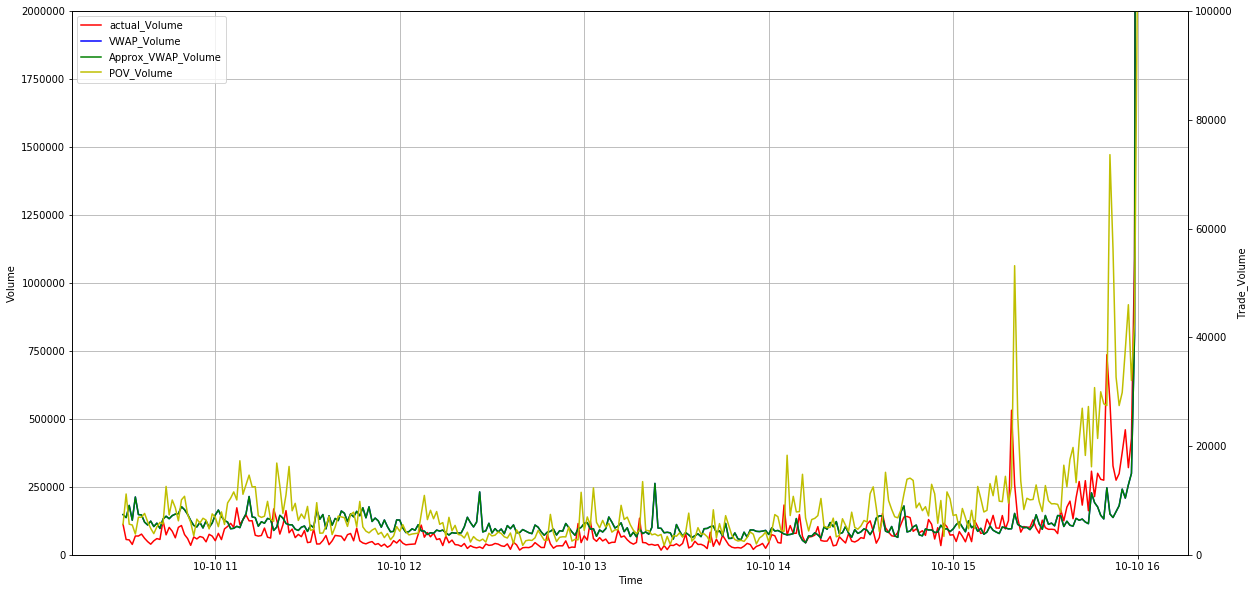

In [13]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

lns1 = ax.plot(VWAP.Time,VWAP.actual_Volume, color = 'r', label = 'actual_Volume')

ax2 = ax.twinx()
lns2 = ax2.plot(VWAP.Time,VWAP.Volume, color = 'b', label = 'VWAP_Volume')
lns3 = ax2.plot(Approx_VWAP.Time,Approx_VWAP.Volume, color = 'g', label = 'Approx_VWAP_Volume')
lns4 = ax2.plot(POV.Time,POV.Volume, color = 'y', label = 'POV_Volume')

lns = lns1 + lns2 + lns3 + lns4
# added these three lines+lns5+lns6
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.grid()
ax.set_xlabel("Time")
ax.set_ylim(bottom = 0, top=2000000)
ax2.set_ylim(bottom = 0, top=100000)
ax.set_ylabel("Volume")
ax2.set_ylabel("Trade_Volume")

plt.show()

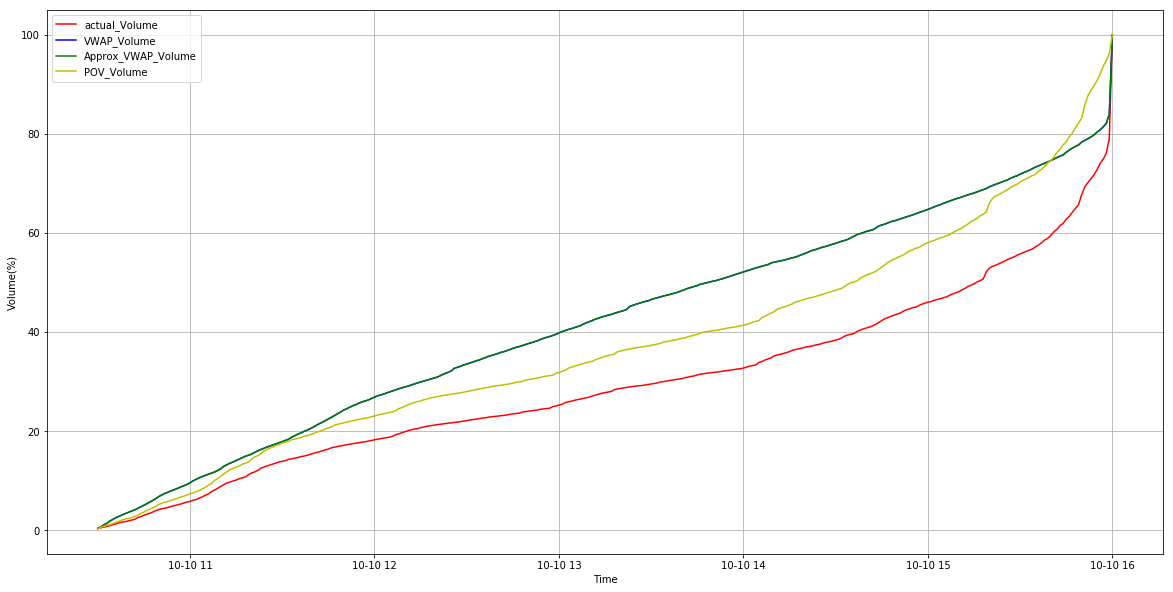

In [14]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

lns1 = ax.plot(VWAP.Time,actual_Volume_pct, color = 'r', label = 'actual_Volume')
lns2 = ax.plot(VWAP.Time,VWAP_Volume_pct, color = 'b', label = 'VWAP_Volume')
lns3 = ax.plot(Approx_VWAP.Time,Approx_VWAP_Volume_pct, color = 'g', label = 'Approx_VWAP_Volume')
lns4 = ax.plot(POV.Time,POV_Volume_pct, color = 'y', label = 'POV_Volume')

lns = lns1 + lns2 + lns3 + lns4
# added these three lines+lns5+lns6
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.grid()
ax.set_xlabel("Time")
ax.set_ylabel("Volume(%)")

plt.show()

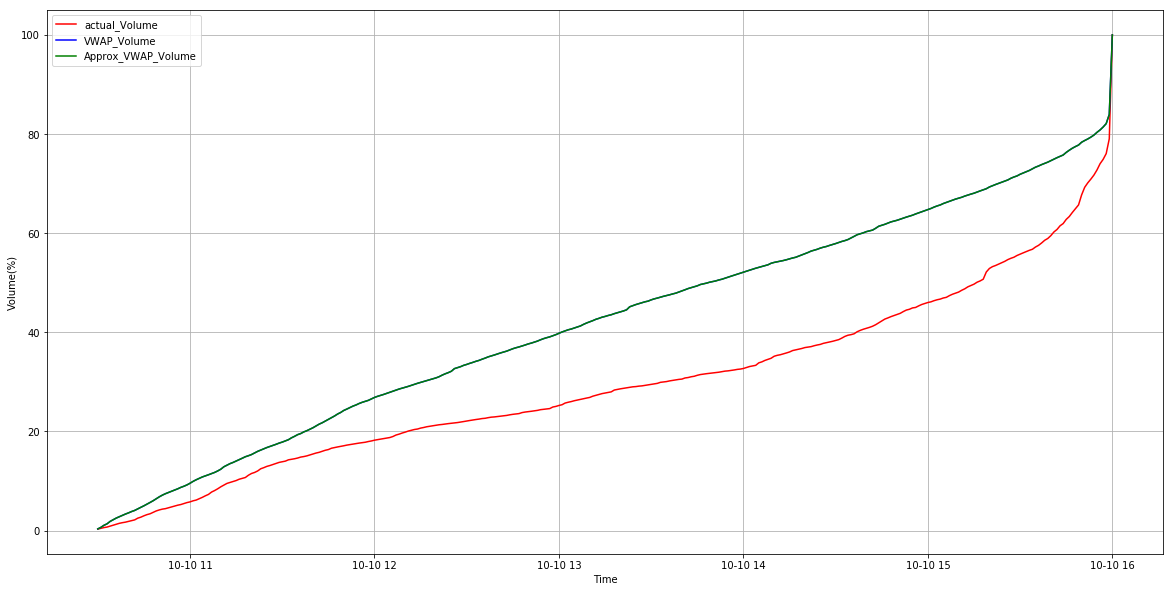

In [18]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

lns1 = ax.plot(VWAP.Time,actual_Volume_pct, color = 'r', label = 'actual_Volume')
lns2 = ax.plot(VWAP.Time,VWAP_Volume_pct, color = 'b', label = 'VWAP_Volume')
lns3 = ax.plot(Approx_VWAP.Time,Approx_VWAP_Volume_pct, color = 'g', label = 'Approx_VWAP_Volume')
#lns4 = ax.plot(POV.Time,POV_Volume_pct, color = 'y', label = 'POV_Volume')

lns = lns1 + lns2 + lns3 #+ lns4
# added these three lines+lns5+lns6
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.grid()
ax.set_xlabel("Time")
ax.set_ylabel("Volume(%)")

plt.show()

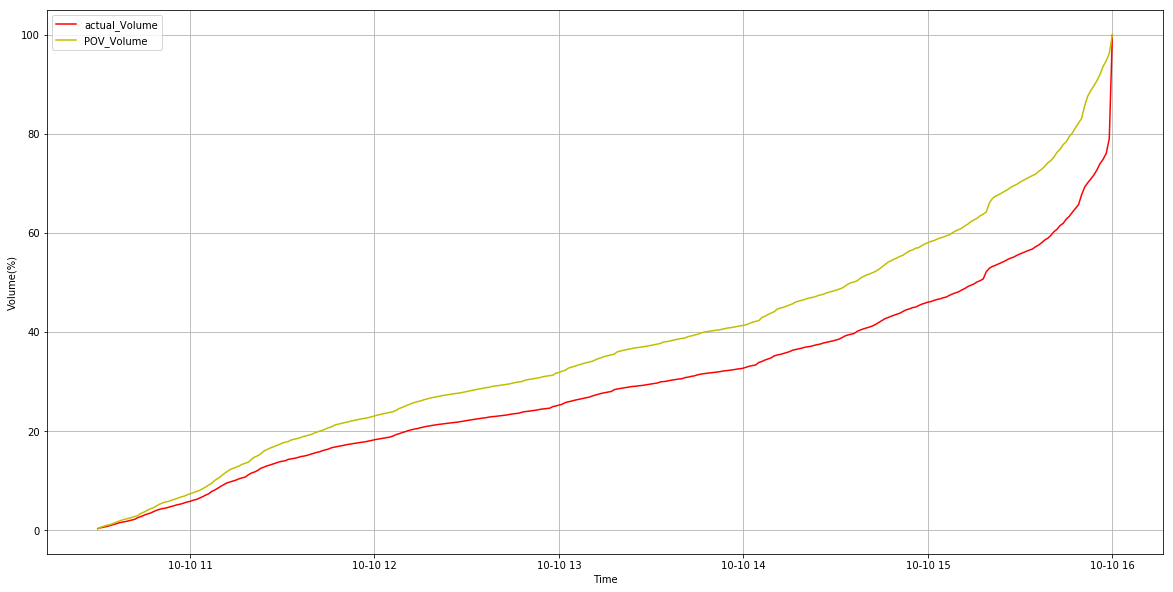

In [16]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

lns1 = ax.plot(VWAP.Time,actual_Volume_pct, color = 'r', label = 'actual_Volume')
#lns2 = ax.plot(VWAP.Time,VWAP_Volume_pct, color = 'b', label = 'VWAP_Volume')
#lns3 = ax.plot(Approx_VWAP.Time,Approx_VWAP_Volume_pct, color = 'g', label = 'Approx_VWAP_Volume')
lns4 = ax.plot(POV.Time,POV_Volume_pct, color = 'y', label = 'POV_Volume')

lns = lns1 + lns4
# added these three lines+lns5+lns6
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.grid()
ax.set_xlabel("Time")
ax.set_ylabel("Volume(%)")

plt.show()